# ERCC ExFold Analysis

* Study: FS_20190404
* Samples: GLDS-235_LVR
* ERCC: Mix 1, N = 38
* ERCC: Mix 2, N = 37

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy import stats
sns.set(rc={'figure.figsize':(9,9)})

In [39]:
%matplotlib inline

In [40]:
ERCC_raw_csv = 'https://github.com/jgalazka/ERCC_analysis/blob/main/data/GLDS-235_rawCounts.csv?raw=true'
Samples_csv = "https://github.com/jgalazka/ERCC_analysis/raw/main/data/GLDS-235_samples_export.csv"
Assays_csv= "https://github.com/jgalazka/ERCC_analysis/raw/main/data/GLDS-235_transcription_profiling_export.csv"
ERCC_info = "https://github.com/jgalazka/ERCC_analysis/raw/main/data/ERCCExFold.txt"
Study_name = 'FS_20190404_GLDS-235_LVR'


In [41]:

ERCC = pd.read_csv(ERCC_raw_csv, sep=',')
ERCC['Study'] = Study_name
ERCC.rename(columns={'Unnamed: 0':'ERCC'}, inplace=True)

In [42]:
meltERCC = ERCC.melt(id_vars=['ERCC', 'Study'])
meltERCC['log2 Count'] = meltERCC['value']+1
meltERCC['log2 Count'] = np.log2(meltERCC['log2 Count'])

# meltERCC

In [43]:
# Make combined sample and assay table
samples = pd.read_csv(Samples_csv)
assay = pd.read_csv(Assays_csv)
merged = samples.merge(assay, on='Sample Name')
merged['Parameter Value:  Read Depth'] = merged['Parameter Value:  Read Depth'].str[:-5]
pd.to_numeric(merged['Parameter Value:  Read Depth'])

# Build Mix dictionary to link sample name to mix added using combined sample and assay table
mix = merged['Parameter Value:  Spike-in Mix Number']
samplename = merged['Sample Name']
mix_dict = dict(zip(samplename, mix))

# Use dictionary to add Mix columns to ercc df
meltERCC['Mix'] = meltERCC['variable'].map(mix_dict)

# meltERCC

In [44]:
# Read ERCC infor including concentrations from ERCC_info.txt table
ercc = pd.read_csv(ERCC_info, sep='\t')
allgroups = ercc['ERCC ID']
groupA = ercc.loc[ercc['subgroup'] == 'A']['ERCC ID']
groupB = ercc.loc[ercc['subgroup'] == 'B']['ERCC ID']
groupC = ercc.loc[ercc['subgroup'] == 'C']['ERCC ID']
groupD = ercc.loc[ercc['subgroup'] == 'D']['ERCC ID']

# Make a dictionary for ERCC concentrations for each mix
mix1_conc_dict = dict(zip(ercc['ERCC ID'], ercc['concentration in Mix 1 (attomoles/ul)']))
mix2_conc_dict = dict(zip(ercc['ERCC ID'], ercc['concentration in Mix 2 (attomoles/ul)']))

# Make a dictionary for ERCC group
group_dict = dict(zip(ercc['ERCC ID'], ercc['subgroup']))

# Add mix concentrations to ercc df.
# First, split df in to Mix 1 and Mix 2
mix1df = meltERCC.loc[meltERCC['Mix'] == 'Mix 1']
mix2df = meltERCC.loc[meltERCC['Mix'] == 'Mix 2']
# Now use the mix 1 and mix 2 conc. dictionaries to add conc. separately
mix1df['Expected conc. (attomoles/ul)'] = mix1df['ERCC'].map(mix1_conc_dict)
mix2df['Expected conc. (attomoles/ul)'] = mix2df['ERCC'].map(mix2_conc_dict)
# Recombined mix 1 and mix 2 df
combineddf = pd.concat([mix1df, mix2df])
# Make new column with expected conc. log2 transformed
combineddf['log2 Expected'] = np.log2(combineddf['Expected conc. (attomoles/ul)'])

# combineddf


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [45]:
#Add read count
#combineddf['Unique Reads'] = combineddf['variable'].map(unique_dict)
#combineddf['Duplicate Reads'] = combineddf['variable'].map(duplicate_dict)
total_dict = dict(zip(merged['Sample Name'], merged['Parameter Value:  Read Depth']))
combineddf['Total Reads'] = combineddf['variable'].map(total_dict)
combineddf['Total Reads'] = pd.to_numeric(combineddf['Total Reads'])

combineddf['Count per million'] = combineddf['value'] / (combineddf['Total Reads'] / 1000000.0)
combineddf['log2 Count per million'] = np.log2(combineddf['Count per million']+1)

# Add ERCC group
combineddf['ERCC group'] = combineddf['ERCC'].map(group_dict)

#combineddf

In [46]:
# combineddf.describe()

In [47]:
# Filter Mix1 log2 CPM and Mix2 log2 CPM in group A 
# Averages of Mix1 log2 CPM and Mix2 log2 CPM
Adf = combineddf.loc[combineddf['ERCC group'] == 'A']

Amix1df = Adf.loc[Adf['Mix']=='Mix 1']
Amix1df['Mix1 log2 CPM'] = Amix1df[Amix1df['log2 Count per million'] > 0]['log2 Count per million'].dropna()
Amix1df = Amix1df.groupby('ERCC')['Mix1 log2 CPM'].agg(np.mean).rename('ave Mix1 log2 CPM')
Amix1df = Amix1df.to_frame()
Amix2df = Adf.loc[Adf['Mix']=='Mix 2']
Amix2df['Mix2 log2 CPM'] = Amix2df[Amix2df['log2 Count per million'] > 0]['log2 Count per million'].dropna()
Amix2df = Amix2df.groupby('ERCC')['Mix2 log2 CPM'].agg(np.mean).rename('ave Mix2 log2 CPM')
Amix2df = Amix2df.to_frame()

adf = Amix1df.merge(Amix2df, on='ERCC', suffixes=('', '_2'))
adf = adf.reset_index()
adf['ave Mix1 log2 CPM/ ave Mix2 log2 CPM'] = (adf['ave Mix1 log2 CPM'] / adf['ave Mix2 log2 CPM'])
adf.to_csv("GroupA.csv")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [48]:
#adf

In [49]:
Bdf = combineddf.loc[combineddf['ERCC group'] == 'B']
Bmix1df = Bdf.loc[Bdf['Mix']=='Mix 1']
Bmix1df['Mix1 log2 CPM'] = Bmix1df[Bmix1df['log2 Count per million'] > 0]['log2 Count per million'].dropna()
Bmix1df = Bmix1df.groupby('ERCC')['Mix1 log2 CPM'].agg(np.mean).rename('ave Mix1 log2 CPM')
Bmix1df = Bmix1df.to_frame()
Bmix2df = Bdf.loc[Bdf['Mix']=='Mix 2']
Bmix2df['Mix2 log2 CPM'] = Bmix2df[Bmix2df['log2 Count per million'] > 0]['log2 Count per million'].dropna()
Bmix2df = Bmix2df.groupby('ERCC')['Mix2 log2 CPM'].agg(np.mean).rename('ave Mix2 log2 CPM')
Bmix2df = Bmix2df.to_frame()

bdf = Bmix1df.merge(Bmix2df, on='ERCC')
bdf = bdf.reset_index()
bdf['ave Mix1 log2 CPM/ ave Mix2 log2 CPM'] = (bdf['ave Mix1 log2 CPM'] / bdf['ave Mix2 log2 CPM'])
bdf.to_csv("GroupB.csv")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [50]:
Cdf = combineddf.loc[combineddf['ERCC group'] == 'C']
Cmix1df = Cdf.loc[Cdf['Mix']=='Mix 1']
Cmix1df['Mix1 log2 CPM'] = Cmix1df[Cmix1df['log2 Count per million'] > 0]['log2 Count per million'].dropna()
Cmix1df = Cmix1df.groupby('ERCC')['Mix1 log2 CPM'].agg(np.mean).rename('ave Mix1 log2 CPM')
Cmix1df = Cmix1df.to_frame()
Cmix2df = Cdf.loc[Cdf['Mix']=='Mix 2']
Cmix2df['Mix2 log2 CPM'] = Cmix2df[Cmix2df['log2 Count per million'] > 0]['log2 Count per million'].dropna()
Cmix2df = Cmix2df.groupby('ERCC')['Mix2 log2 CPM'].agg(np.mean).rename('ave Mix2 log2 CPM')
Cmix2df = Cmix2df.to_frame()

cdf = Cmix1df.merge(Cmix2df, on='ERCC')
cdf = cdf.reset_index()
cdf['ave Mix1 log2 CPM/ ave Mix2 log2 CPM'] = (cdf['ave Mix1 log2 CPM'] / cdf['ave Mix2 log2 CPM'])
cdf.to_csv("GroupC.csv")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [51]:
Ddf = combineddf.loc[combineddf['ERCC group'] == 'D']
Dmix1df = Ddf.loc[Ddf['Mix']=='Mix 1']
Dmix1df['Mix1 log2 CPM'] = Dmix1df[Dmix1df['log2 Count per million'] > 0]['log2 Count per million'].dropna()
Dmix1df = Dmix1df.groupby('ERCC')['Mix1 log2 CPM'].agg(np.mean).rename('ave Mix1 log2 CPM')
Dmix1df = Dmix1df.to_frame()
Dmix2df = Ddf.loc[Ddf['Mix']=='Mix 2']
Dmix2df['Mix2 log2 CPM'] = Dmix2df[Dmix2df['log2 Count per million'] > 0]['log2 Count per million'].dropna()
Dmix2df = Dmix2df.groupby('ERCC')['Mix2 log2 CPM'].agg(np.mean).rename('ave Mix2 log2 CPM')
Dmix2df = Dmix2df.to_frame()

ddf = Dmix1df.merge(Dmix2df, on='ERCC')
ddf = ddf.reset_index()
ddf['ave Mix1 log2 CPM/ ave Mix2 log2 CPM'] = (ddf['ave Mix1 log2 CPM'] / ddf['ave Mix2 log2 CPM'])
ddf.to_csv("GroupD.csv")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


### ERCC group A (N = 23 max)

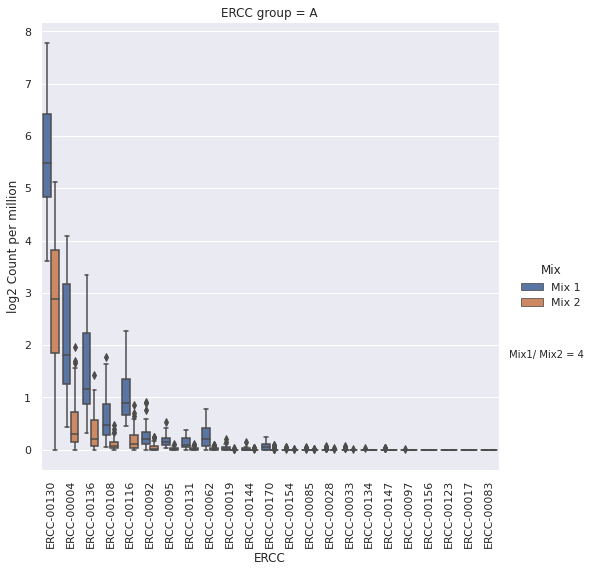

In [52]:
a = sns.catplot(x="ERCC", y="log2 Count per million", order=groupA, hue="Mix",data=combineddf[combineddf['ERCC'].isin(groupA)], kind="box", col="ERCC group", height=7, aspect=1)
a.set_xticklabels(rotation=90)
plt.text(23,1.75,"Mix1/ Mix2 = 4")
sns.set(style="darkgrid")
figApath = Study_name + '_groupA.pdf'
a.savefig(figApath, bbox_inches='tight')

# of ERCC (out of 23) = 16


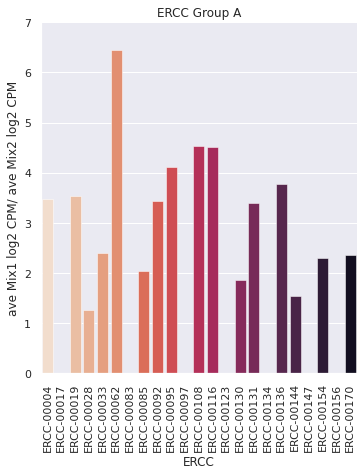

In [53]:
a = sns.catplot(x="ERCC", y="ave Mix1 log2 CPM/ ave Mix2 log2 CPM", palette="rocket_r", data=adf, kind="bar", 
               height=5.5, aspect=1, linewidth=0.5)
a.set_xticklabels(rotation=90)
plt.title("ERCC Group A")
sns.set(style="whitegrid")
a.set(ylim=(0, 7))
figApath = Study_name + '_groupA1.pdf'
a.savefig(figApath, bbox_inches='tight')
print('# of ERCC (out of 23) =', adf['ave Mix1 log2 CPM/ ave Mix2 log2 CPM'].count())

### ERCC group B (N = 23 max)

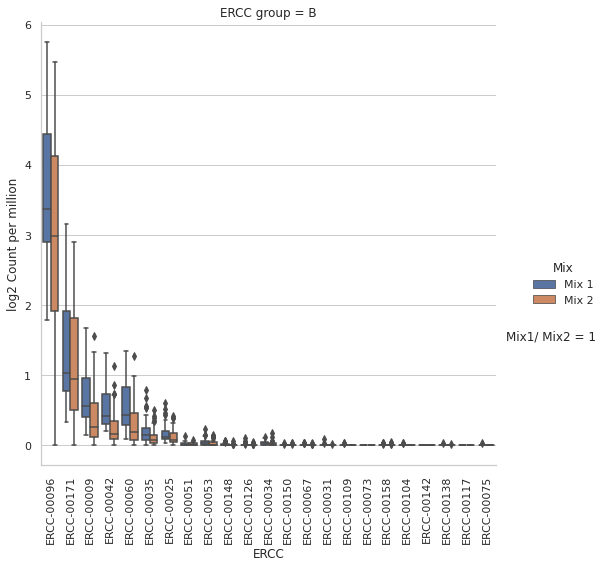

In [54]:
b = sns.catplot(x="ERCC", y="log2 Count per million", order=groupB, hue="Mix", data=combineddf[combineddf['ERCC'].isin(groupB)], kind="box", col="ERCC group", height=7, aspect=1)
b.set_xticklabels(rotation=90)
plt.text(23,1.5,"Mix1/ Mix2 = 1")
sns.set(style="darkgrid")
figBpath = Study_name + '_groupB.pdf'
b.savefig(figBpath, bbox_inches='tight')

# of ERCC (out of 23) = 17


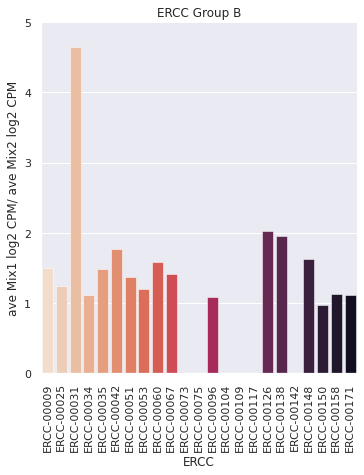

In [55]:
b = sns.catplot(x="ERCC", y="ave Mix1 log2 CPM/ ave Mix2 log2 CPM", palette="rocket_r", data=bdf, kind="bar", 
               height=5.5, aspect=1, linewidth=0.5)
b.set_xticklabels(rotation=90)
plt.title("ERCC Group B")
sns.set(style="whitegrid")
b.set(ylim=(0, 5))
figBpath = Study_name + '_groupB1.pdf'
b.savefig(figBpath, bbox_inches='tight')
print('# of ERCC (out of 23) =', bdf['ave Mix1 log2 CPM/ ave Mix2 log2 CPM'].count())

### ERCC group C (N = 23 max)

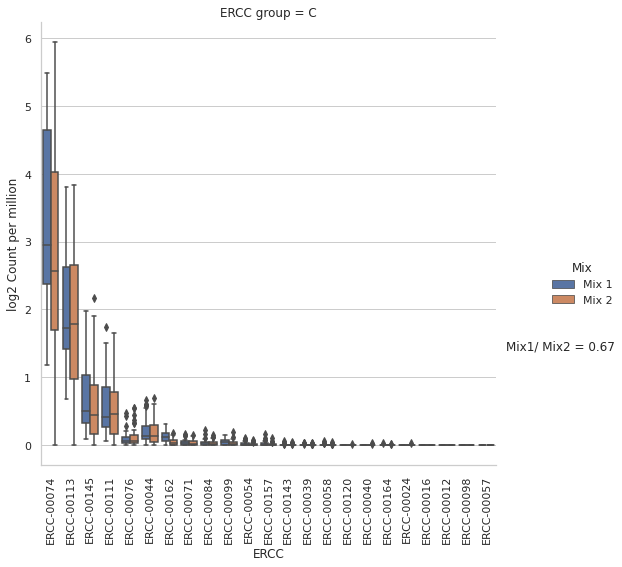

In [56]:
c = sns.catplot(x="ERCC", y="log2 Count per million", order=groupC, hue="Mix", data=combineddf[combineddf['ERCC'].isin(groupC)], kind="box", col="ERCC group", height=7, aspect=1)
c.set_xticklabels(rotation=90)
plt.text(23,1.4,"Mix1/ Mix2 = 0.67")
sns.set(style="darkgrid")
figCpath = Study_name + '_groupC.pdf'
c.savefig(figCpath, bbox_inches='tight')

# of ERCC (out of 23) = 16


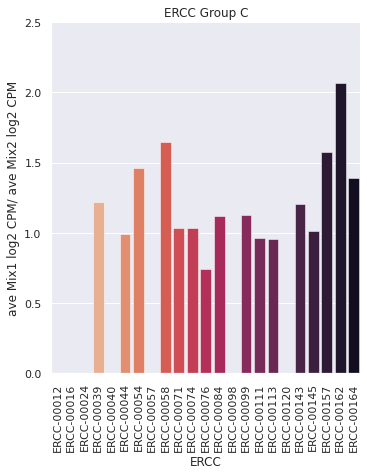

In [57]:
c = sns.catplot(x="ERCC", y="ave Mix1 log2 CPM/ ave Mix2 log2 CPM", palette="rocket_r", data=cdf, kind="bar", 
               height=5.5, aspect=1, linewidth=0.5)
c.set_xticklabels(rotation=90)
plt.title("ERCC Group C")
sns.set(style="whitegrid")
c.set(ylim=(0, 2.5))
figCpath = Study_name + '_groupC1.pdf'
c.savefig(figCpath, bbox_inches='tight')
print('# of ERCC (out of 23) =', cdf['ave Mix1 log2 CPM/ ave Mix2 log2 CPM'].count())

### ERCC group D (N = 23 max)

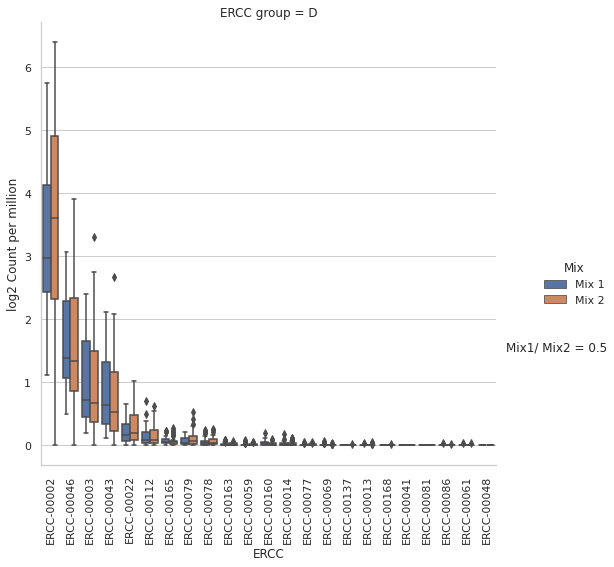

In [58]:
d = sns.catplot(x="ERCC", y="log2 Count per million", order=groupD, hue="Mix", data=combineddf[combineddf['ERCC'].isin(groupD)], col="ERCC group", kind="box", height=7, aspect=1)
d.set_xticklabels(rotation=90)
plt.text(23,1.5,"Mix1/ Mix2 = 0.5")
sns.set(style="darkgrid")
figDpath = Study_name + '_groupD.pdf'
d.savefig(figDpath, bbox_inches='tight')

# of ERCC (out of 23) = 18


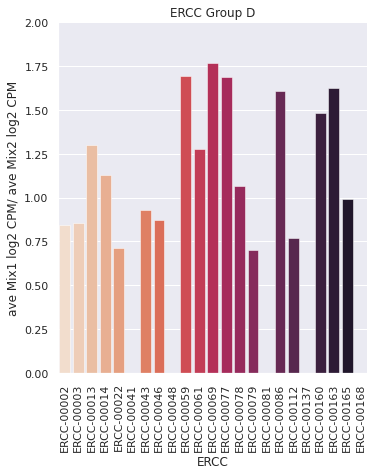

In [59]:
d = sns.catplot(x="ERCC", y="ave Mix1 log2 CPM/ ave Mix2 log2 CPM", palette="rocket_r", data=ddf, kind="bar", 
               height=5.5, aspect=1, linewidth=0.5)
d.set_xticklabels(rotation=90)
plt.title("ERCC Group D")
sns.set(style="whitegrid")
d.set(ylim=(0, 2))
figDpath = Study_name + '_groupD1.pdf'
d.savefig(figDpath, bbox_inches='tight')
print('# of ERCC (out of 23) =', ddf['ave Mix1 log2 CPM/ ave Mix2 log2 CPM'].count())

## ERCC ExFold

In [60]:
# ERCC ExFold 
ercc

,Re-sort ID,ERCC ID,subgroup,concentration in Mix 1 (attomoles/ul),concentration in Mix 2 (attomoles/ul),expected fold-change ratio,log2(Mix 1/Mix 2)
0,1,ERCC-00130,A,30000.000000,7500.000000,4.0,2.0
1,2,ERCC-00004,A,7500.000000,1875.000000,4.0,2.0
2,3,ERCC-00136,A,1875.000000,468.750000,4.0,2.0
3,4,ERCC-00108,A,937.500000,234.375000,4.0,2.0
4,5,ERCC-00116,A,468.750000,117.187500,4.0,2.0
...,...,...,...,...,...,...,...
87,88,ERCC-00041,D,0.228882,0.457764,0.5,-1.0
88,89,ERCC-00081,D,0.228882,0.457764,0.5,-1.0
89,90,ERCC-00086,D,0.114441,0.228882,0.5,-1.0
90,91,ERCC-00061,D,0.057220,0.114441,0.5,-1.0


In [61]:
ercc["log2 Mix1"] = np.log2(ercc['concentration in Mix 1 (attomoles/ul)'])
ercc["log2 Mix2"] = np.log2(ercc['concentration in Mix 2 (attomoles/ul)'])
#ercc

### ERCC ExFold all groups

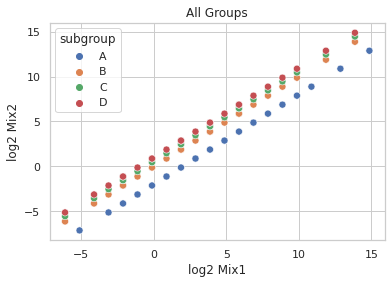

In [62]:
erccPlotAll = sns.scatterplot(x="log2 Mix1", y="log2 Mix2", data=ercc, hue="subgroup", s=50)
sns.set(style="darkgrid")
plt.title("All Groups")
figEpath = Study_name + '_all.pdf'
figE = erccPlotAll.get_figure()
figE.savefig(figEpath, bbox_inches='tight')

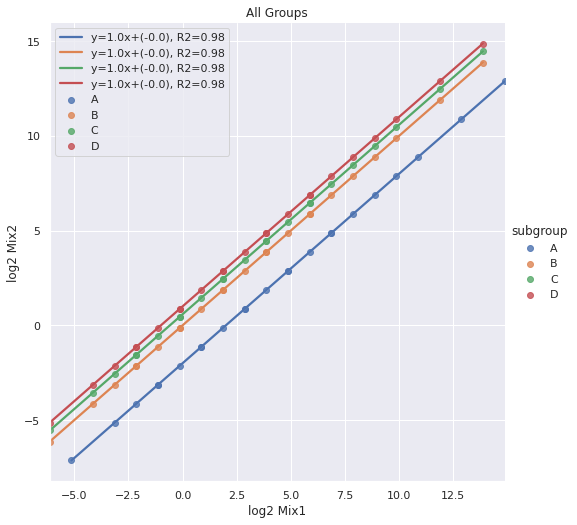

In [63]:
slope, intercept, r_value, p_value, std_err = stats.linregress(ercc['log2 Mix1'], ercc['log2 Mix2'])
erccPlotAll = sns.lmplot(x="log2 Mix1", y="log2 Mix2", data=ercc, hue="subgroup", line_kws={'label':"y={0:.1f}x+({1:.1f}), R2={2:.2f}".format(slope,intercept,r_value)}, 
                         height=7, aspect=1, legend=True)
ax = erccPlotAll.axes[0, 0]
ax.legend()
leg = ax.get_legend()
sns.set(style="darkgrid")
plt.title("All Groups")
figEpath = Study_name + '_all1.pdf'
figE.savefig(figEpath, bbox_inches='tight')

## Count = 0 in Study

In [64]:
below = combineddf[combineddf['value'] == 0]

In [65]:
#below

In [66]:
#below.describe()

In [67]:
print('# of 0 count =', below['value'].count())

# of 0 count = 2792012


In [68]:
belowERCC = below['ERCC'].unique()
print('# of unique ERCC with 0 count =', np.count_nonzero(belowERCC))

# of unique ERCC with 0 count = 52575


In [69]:
ercc['Below threshold'] = ercc['ERCC ID'].isin(belowERCC)

### ERCC group A with count = 0
* True: Count = 0
* False: Count > 0

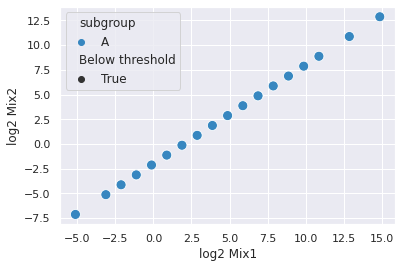

In [70]:
erccPlotA = sns.scatterplot(x="log2 Mix1", y="log2 Mix2", data=ercc[ercc['ERCC ID'].isin(groupA)],
                            palette="Blues_d", hue="subgroup", style="Below threshold", s=100)

In [71]:
combineddf.to_csv("FS_20190404_GLDS-235_LVR_analysis.csv")

In [72]:
figApath, figBpath, figCpath, figDpath = Study_name+'_all.pdf', Study_name+'_all.pdf', Study_name+'_all.pdf', Study_name+'_all.pdf'